## Introduction

Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was to predict which previously purchased products will be in a user’s next order.

## Problem Definition

The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the past behaviour of a user while train and test orders regard the future behaviour that we need to predict. As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). For the train orders Instacart reveals the results (i.e. the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. The setting of the Instacart problem is described in the figure below.


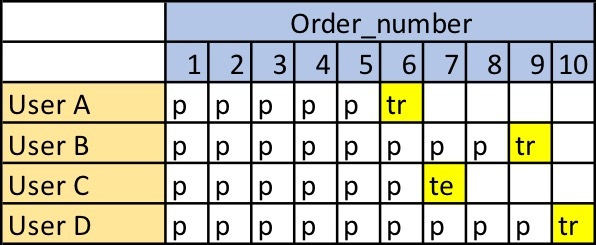

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. This is a classification problem because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below).

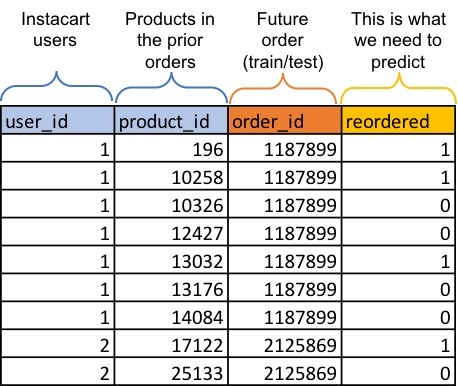

As a result we need to come up and calculate various predictor variables (X) that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

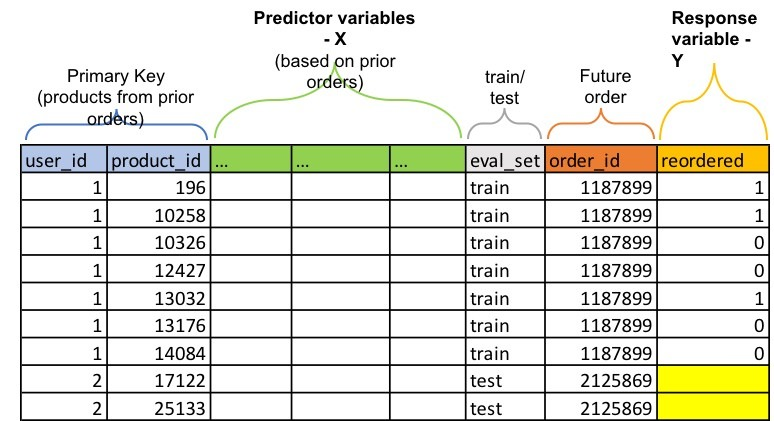

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Importing basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()

In [ ]:
import zipfile

dataset_orders = "orders.csv"
dataset_products = 'products.csv'
dataset_departments = 'departments.csv'
dataset_aisles = 'aisles.csv'
dataset_orders_train = "order_products__train.csv"
dataset_orders_prior = "order_products__prior.csv"

directory = "../input/instacart-market-basket-analysis/"
archive_orders = zipfile.ZipFile(directory+dataset_orders+".zip","r")
archive_products = zipfile.ZipFile(directory+dataset_products+".zip","r")
archive_departments = zipfile.ZipFile(directory+dataset_departments+".zip","r")
archive_aisles = zipfile.ZipFile(directory+dataset_aisles+".zip","r")
archive_orders_train = zipfile.ZipFile(directory+dataset_orders_train+".zip","r")
archive_orders_prior = zipfile.ZipFile(directory+dataset_orders_prior+".zip","r")

In [ ]:
# Reading files

orders_df = pd.read_csv(archive_orders.open('orders.csv'))
products_df = pd.read_csv(archive_products.open('products.csv'))
departments_df = pd.read_csv(archive_departments.open('departments.csv'))
aisles_df = pd.read_csv(archive_aisles.open('aisles.csv'))
orders_train_df = pd.read_csv(archive_orders_train.open('order_products__train.csv'))
orders_prior_df = pd.read_csv(archive_orders_prior.open('order_products__prior.csv'))

orders: This table includes all orders, namely prior, train, and test. It has single primary key (order_id).

order_products_train: This table includes training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).

order_products_prior : This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).

products: This table includes all products. It has a single primary key (product_id)

aisles: This table includes all aisles. It has a single primary key (aisle_id)

departments: This table includes all departments. It has a single primary key (department_id)

In [ ]:
# Checking orders df

orders_df.head()

In [ ]:
orders_df.info()

In [ ]:
orders_df.isnull().sum()

In [ ]:
# products_df

products_df.head()

In [ ]:
departments_df.head()

In [ ]:
aisles_df.head()

In [ ]:
orders_train_df.head()

In [ ]:
orders_prior_df.head()

As we could see, orders.csv has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.

The columns present in order_products_train and order_products_prior are same. Then what is the difference between these files.?

As mentioned earlier, in this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.


In [ ]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Let's get unique count of each type

def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

That is, 206209 are total customers given out of which 131209 customers are given as train set and we need to predict on 75k customers.

Now let us validate the claim that 4 to 100 orders of a customer are given.

In [ ]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So there are no orders less than 4 and is max capped at 100 as given in the data page.

Now let us see how the ordering habit changes with day of week.

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

Now we shall see how the distribution is with respect to time of the day.

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

So majority of the orders are made during day time. Now let us combine the day of week and hour of day to see the distribution.

In [ ]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

Seems Satuday evenings and Sunday mornings are the prime time for orders.

Now let us check the time interval between the orders.

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set

In [ ]:
# percentage of re-orders in prior set
orders_prior_df.reordered.sum() / orders_prior_df.shape[0]

In [ ]:
# percentage of re-orders in train set

orders_train_df.reordered.sum() / orders_train_df.shape[0]

On an average, about 59% of the products in an order are re-ordered products.

**Most Ordered Product**

In [ ]:
productsCount = orders_train_df["product_id"].value_counts().to_frame()
productsCount["count"] = productsCount.product_id
productsCount["product_id"] = productsCount.index
mergedData = pd.merge(productsCount,products_df,how="left",on="product_id").sort_values(by="count",ascending=False)

fig,ax = plt.subplots()
fig.set_size_inches(25,10)
sns.barplot(data=mergedData.head(30),x="product_name",y="count",ax=ax,orient="v")
ax.set(xlabel='Product Names',ylabel="Count",title="Best Selling Products")
plt.xticks(rotation=90)

mergedData.head(10)

In [ ]:
# Top reordered products

productsCountReordered = orders_train_df[orders_train_df["reordered"]==1]["product_id"].value_counts().to_frame()
productsCountReordered["reordered_count"] = productsCountReordered.product_id
productsCountReordered["product_id"] = productsCountReordered.index
productCountReorderedMerged = pd.merge(productsCount,productsCountReordered,how="left",on="product_id").sort_values(by="count",ascending=False)
productCountReorderedMerged["reordered_ratio"] = productCountReorderedMerged["reordered_count"]/productCountReorderedMerged["count"]
productCountReorderedMerged.sort_values(by="reordered_ratio",ascending=False,inplace=True)
productMerged = pd.merge(productCountReorderedMerged,products_df,how="left",on="product_id")

fig,ax = plt.subplots()
fig.set_size_inches(25,10)
sns.barplot(data=productMerged[productMerged["count"]>40].head(30),x="product_name",y="reordered_ratio",ax=ax,orient="v")
ax.set(xlabel='Product Names',ylabel="Count",title="Top Reordered Products")
ax.set_ylim(0.85,.95)
plt.xticks(rotation=90)

productMerged.head(10)

# Department wise reorder ratio

Let's merge products, department & aisles together

In [ ]:
order_products_prior_df = pd.merge(orders_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

In [ ]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Dairy eggs has highest reorder ratio while personal care has lowest

### Add to cart - Reorder ratio

In [ ]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later and this is quite reasonable as well**